## Health Care for All Case Study using Pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

In [2]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [3]:
from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

<b> We begin by loading the precleaned data set

In [4]:
hk_df= pd.read_csv("hk_df_cleaned.csv")

In [5]:
hk_df.columns # inspect the column names

Index(['index', 'state', 'gender', 'median_home_val', 'avg_fam_income',
       'avg_household_income', 'med_fam_income', 'median_household_income',
       'hvp1', 'per_capita_income', 'pobc2', 'avggift', 'domain', 'target_d',
       'med_fam_income_binned'],
      dtype='object')

<b> checking correlations between numerical variables

In [ ]:
sns.pairplot(hk_df.select_dtypes(np.number)) # pairplot generates a grid of scatter plots for all numerical variables except on the diagonal where it displays distributions

In [ ]:
plt.scatter(x=hk_df['med_fam_income'], y=hk_df['avg_household_income'],c='g') # note the correlation between income sources


<b> Plotting the correlation heatmap

In [ ]:
corr = hk_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

<b> Removing highly correlated columns


In [ ]:
CORR_THRESH = 0.80
corr_matrix=hk_df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
corrd_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORR_THRESH)]
hk_df.drop(corrd_cols,axis=1,inplace=True)
hk_df.columns

In [ ]:
hk_df.hist(figsize=(11,12))

<b> Distribution of "median home value" is skewed towards lower incomes

In [ ]:
sns.displot((hk_df['median_home_val']), bins=20)

## X,y, one-hot, and test/train

In [6]:
X = hk_df.drop('target_d', axis=1)
y = hk_df.target_d

In [7]:
numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(object)

In [8]:
numericalX

,index,median_home_val,avg_fam_income,avg_household_income,med_fam_income,median_household_income,hvp1,per_capita_income,pobc2,avggift
0,0,1158.598192,520.0,466,430.0,392,7,21975.0,16,28
1,1,537.000000,473.0,410,415.0,365,0,19387.0,89,5
2,2,725.000000,436.0,361,340.0,301,3,18837.0,17,4
3,3,1158.598192,413.0,399,407.0,401,7,14014.0,74,27
4,4,995.000000,348.0,316,280.0,252,0,17991.0,6,6
...,...,...,...,...,...,...,...,...,...,...
3986,4018,632.000000,388.0,339,336.0,279,2,12653.0,71,8
3987,4019,595.000000,274.0,262,263.0,252,0,11132.0,11,14
3988,4020,2707.000000,537.0,538,504.0,507,80,16165.0,54,12
3989,4021,2666.000000,653.0,612,609.0,535,63,24745.0,45,12


In [9]:
med=pd.DataFrame(hk_df.median_home_val)

In [10]:
y.isna().any()

False

array([[<Axes: title={'center': 'median_home_val'}>]], dtype=object)

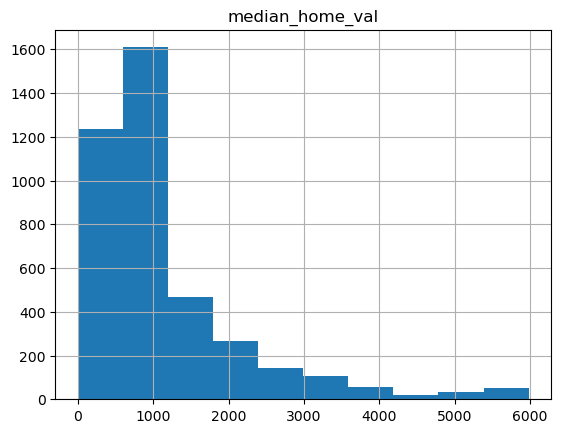

In [11]:
med.hist()

In [12]:
y.dropna(inplace=True)

In [13]:
y

0       100.0
1         7.0
2         5.0
3        38.0
4         5.0
        ...  
3986      5.0
3987     20.0
3988     22.0
3989     21.0
3990     25.0
Name: target_d, Length: 3991, dtype: float64

In [14]:
y = pd.DataFrame(y)

In [15]:
remove_outliers(pd.DataFrame(y))

,target_d
0,NaN
1,7.0
2,5.0
3,NaN
4,5.0
...,...
3986,5.0
3987,20.0
3988,22.0
3989,21.0


In [16]:
# one-hot encode the categorical features
X = pd.concat([pd.get_dummies(X[categoricalX.columns],drop_first=True),
               remove_outliers(X[numericalX.columns])],
              axis=1)

C:\Users\Aleks\AppData\Local\Temp\ipykernel_27452\504253479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c][condition]  # Filter out the outliers


In [17]:
X.isna().any()

state_AE                   False
state_AK                   False
state_AL                   False
state_AP                   False
state_AR                   False
                           ...  
median_household_income     True
hvp1                        True
per_capita_income           True
pobc2                      False
avggift                     True
Length: 82, dtype: bool

In [18]:
hk_df.columns

Index(['index', 'state', 'gender', 'median_home_val', 'avg_fam_income',
       'avg_household_income', 'med_fam_income', 'median_household_income',
       'hvp1', 'per_capita_income', 'pobc2', 'avggift', 'domain', 'target_d',
       'med_fam_income_binned'],
      dtype='object')

In [19]:
na_idcs = X[X.isna().any(axis=1)].index
X = pd.DataFrame(X).drop(na_idcs)
y = pd.DataFrame(y).drop(na_idcs)

In [20]:
na_idcs_y = y[y.isna().any(axis=1)].index
X = pd.DataFrame(X).drop(na_idcs_y)
y = pd.DataFrame(y).drop(na_idcs_y)

In [21]:
y.isna().any()

target_d    False
dtype: bool

In [22]:
# test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.head(3)

,state_AE,state_AK,state_AL,state_AP,state_AR,state_AZ,state_Arizona,state_CA,state_CO,state_CT,...,index,median_home_val,avg_fam_income,avg_household_income,med_fam_income,median_household_income,hvp1,per_capita_income,pobc2,avggift
3331,0,0,0,0,0,0,0,0,0,0,...,3363,439.0,212.0,168.0,189.0,134.0,0.0,7525.0,77,5.0
1403,0,0,1,0,0,0,0,0,0,0,...,1419,710.0,457.0,433.0,429.0,402.0,0.0,14119.0,50,10.0
1978,0,0,0,0,0,0,0,0,0,0,...,1994,748.0,423.0,369.0,372.0,352.0,1.0,13998.0,62,10.0


## Continuous transformations

<b> Power Transformer </b>: we use a power transformer to make the distribution of this variable more normal-like.  It improves modeling errors in linear regression.

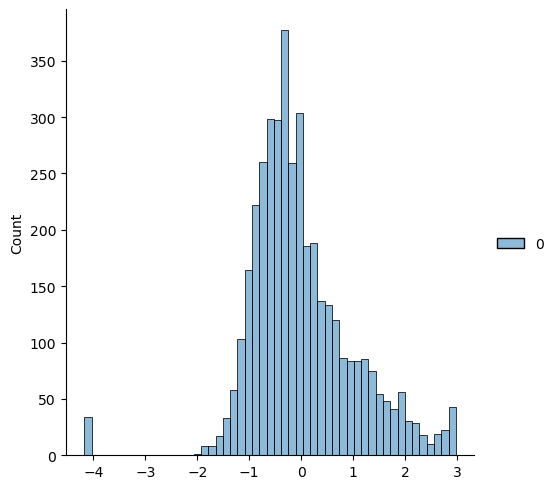

In [23]:
pt = PowerTransformer()
med_home_val_transformed=pt.fit_transform(hk_df['median_home_val'].to_numpy().reshape(-1,1))
sns.displot(med_home_val_transformed)

In [24]:
print("the parameters used to transform median_home_val are")
pt.get_params(),pt.lambdas_ # parameter used in the power transformation

the parameters used to transform median_home_val are


({'copy': True, 'method': 'yeo-johnson', 'standardize': True},
 array([0.24451556]))

In [25]:
X_train

,state_AE,state_AK,state_AL,state_AP,state_AR,state_AZ,state_Arizona,state_CA,state_CO,state_CT,...,index,median_home_val,avg_fam_income,avg_household_income,med_fam_income,median_household_income,hvp1,per_capita_income,pobc2,avggift
3331,0,0,0,0,0,0,0,0,0,0,...,3363,439.0,212.0,168.0,189.0,134.0,0.0,7525.0,77,5.0
1403,0,0,1,0,0,0,0,0,0,0,...,1419,710.0,457.0,433.0,429.0,402.0,0.0,14119.0,50,10.0
1978,0,0,0,0,0,0,0,0,0,0,...,1994,748.0,423.0,369.0,372.0,352.0,1.0,13998.0,62,10.0
3553,0,0,0,0,0,0,0,0,0,0,...,3585,633.0,391.0,351.0,326.0,309.0,1.0,13407.0,63,12.0
3351,0,0,0,0,0,0,0,0,0,0,...,3383,804.0,441.0,400.0,408.0,366.0,7.0,15041.0,54,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,0,0,0,0,0,0,0,0,0,0,...,2090,417.0,326.0,258.0,300.0,277.0,0.0,10308.0,89,14.0
433,0,0,0,0,0,0,0,0,0,0,...,436,314.0,280.0,236.0,224.0,206.0,0.0,10245.0,90,13.0
2491,0,0,0,0,0,0,0,0,0,0,...,2522,236.0,317.0,285.0,250.0,203.0,0.0,12434.0,75,5.0
3343,0,0,0,0,0,0,0,0,0,0,...,3375,1093.0,478.0,434.0,413.0,366.0,7.0,19287.0,15,9.0


In [26]:
ct = ColumnTransformer([("pt", pt, list(numericalX.columns))],
                        remainder='drop', verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train))
X_test_ct = pd.DataFrame(ct.transform(X_test))

[ColumnTransformer] ............ (1 of 1) Processing pt, total=   0.2s


In [27]:
X_train_ct = pd.DataFrame(X_train_ct)
X_test_ct

,0,1,2,3,4,5,6,7,8,9
0,1.408987,1.510782,1.231257,1.484761,1.329766,1.694943,1.552959,1.623183,0.062413,-0.241322
1,-0.459309,1.077013,2.087438,1.939550,2.054337,1.884777,0.179048,1.849039,0.572884,0.004278
2,0.596937,0.791566,1.752781,1.993322,1.665296,1.897179,1.359960,0.992016,-0.134367,1.156624
3,-0.199207,-0.406431,0.075011,0.395396,0.241060,0.580066,-0.939456,-0.233476,0.112290,0.004278
4,1.383692,-0.109015,0.281149,0.361014,0.370295,0.555394,-0.939456,-0.045651,0.944912,0.635861
...,...,...,...,...,...,...,...,...,...,...
902,-0.284782,-0.423705,-0.094517,-1.291955,-0.157572,-1.579363,-0.939456,-0.707092,-0.696702,0.440100
903,0.033179,0.390734,0.364592,0.554954,0.395772,0.669364,0.873646,0.167526,0.625315,0.230377
904,-1.012795,-0.825879,-1.137092,-1.075104,-0.910096,-0.740023,-0.939456,-1.327370,0.365627,1.992909
905,-2.029144,0.027575,-0.242015,-0.641975,-0.590597,-0.706124,-0.939456,0.839313,-0.960539,1.867825


## Predictive Modeling 

### OLS using StatsModels

In [28]:
y_train

,target_d
3331,10.0
1403,11.0
1978,30.0
3553,16.0
3351,21.0
...,...
2059,15.0
433,20.0
2491,7.0
3343,10.0


In [30]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model = sm.OLS(y_train, X_train_const_ct).fit()
predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model.predict(X_test_const_ct)
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               target_d   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     198.5
Date:                Mon, 10 Jul 2023   Prob (F-statistic):          6.49e-295
Time:                        15:39:47   Log-Likelihood:                -6280.7
No. Observations:                2116   AIC:                         1.258e+04
Df Residuals:                    2105   BIC:                         1.265e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0340      0.103    127.020      0.000      12.833      13.235
x1            -0.1788      0.103     -1.737      0.082      -0.381       0.023
x2            -0.1736      0.192     -0.903      0.367      -0.551       0.203
x3            -0.1393      0.655     -0.213      0.832      -1.424       1.146
x4             0.3514      0.730      0.481      0.630      -1.080       1.783
x5             0.1736      0.506      0.343      0.732      -0.819       1.166
x6            -0.1339      0.561     -0.239      0.811      -1.235       0.967
x7            -0.1988      0.150     -1.323      0.186      -0.493       0.096
x8             0.1350      0.232      0.581      0.561      -0.320       0.590
x9             0.0365      0.121      0.301      0.764      -0.201       0.275
x10            4.5552      0.104     43.967      0.000       4.352       4.758
==============================================================================
Omnibus:                      102.523   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.982
Skew:                           0.344   Prob(JB):                     3.75e-44
Kurtosis:                       4.340   Cond. No.                         24.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### OLS using Scikit Learn

Model fitting

In [ ]:
model=LinearRegression()    # model
model.fit(X_train_ct, y_train)   # model train

<b> model parameters

In [ ]:
model.coef_

In [ ]:
model.intercept_

Making prediction

In [ ]:
y_pred = pd.DataFrame(model.predict(X_test_ct),columns = ['target_d'] )      # model prediction
y_pred_train =  pd.DataFrame(model.predict(X_train_ct),columns = ['target_d'])

## Evaluating Model Performance

In [ ]:
y_pred

In [ ]:
result=pd.DataFrame({"y_test": list(y_test['target_d']),"y_pred": list(y_pred['target_d'])})

In [ ]:
result

In [ ]:
# Make a scatterplot of y_pred vs y
# Question: What kind of plot will you get if all the all the predictions are perfect?
# Answer: A straight line!

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_pred.to_numpy()-y_test.to_numpy(),"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<b>more fancy using seaborn

In [ ]:
yp_ = y_pred.to_numpy()
yt_ = y_test.to_numpy()
sns.regplot(x=yp_,y=yt_,scatter_kws={"color": "red"}, line_kws={"color": "black"})

### Error metrics

In [ ]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))
##prediction on the train set
print(mse(y_train,y_pred_train))

In [ ]:
R2=r2_score(y_test,y_pred)
R2

In [ ]:
R2_test=model.score(X_test_ct,y_test)
R2_train=model.score(X_train_ct,y_train)
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

## Feature Importances

In [ ]:
feature_importances = pd.DataFrame(data={
    'Variable': X_train_ct.columns,
    'Importance': abs(model.coef_.reshape(len(X_train_ct.columns),))
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances

In [ ]:
plt.bar(x=features_importances['Variable'].iloc[:10], height=features_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation='horizontal')
plt.show()